In [1]:
from preprocessamento import Preprocessing
anomalos = """IMU_earthquake.csv
IMU_extra_weigth.csv
IMU_hitting_arm.csv
IMU_hitting_platform.csv
IMU_magnet.csv""".split('\n')
pp = Preprocessing(arquivos_anomalos=anomalos)

pp.preprocessar_todos()

/guaxim/Projetos/tosh/ai/anomaly-detection/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas

Fazendo Resampling e Interpolate de IMU_10Hz.csv
Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 10)

Fazendo Resampling e Interpolate de IMU_earthquake.csv
Buracos gerados pelo alinhamento: 638
Resampling concluído. Novo shape: (11428, 10)

Fazendo Resampling e Interpolate de IMU_extra_weigth.csv
Buracos gerados pelo alinhamento: 709
Resampling concluído. Novo shape: (10902, 10)

Fazendo Resampling e Interpolate de IMU_hitting_arm.csv
Buracos gerados pelo alinhamento: 676
Resampling concluído. Novo shape: (11943, 10)

Fazendo Resampling e Interpolate de IMU_hitting_platform.csv
Buracos gerados pelo alinhamento: 900
Resampling concluído. Novo shape: (14992, 10)

Fazendo Resampling e Interpol

In [27]:
X_train,X_val,X_test = pp.normal_splits
anomalo_tests = [ano[2] for ano in pp.anomalo_splits]
randidx = int(len(X_train)*0.83)
randomNormalWindow = np.array([X_train[randidx+dif] for dif in range(-1,3)])

In [24]:
randomNormalWindow.shape

(4, 600)

/tmp/ipykernel_90060/1432385784.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_normal = plt.cm.get_cmap('Blues')(np.linspace(0.3, 1, len(all_normal_points)))
/tmp/ipykernel_90060/1432385784.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_anomaly = plt.cm.get_cmap('Reds')(np.linspace(0.3, 1, len(cand_w)))
/tmp/ipykernel_90060/1432385784.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_anomaly = plt.cm.get_cmap('Reds')(np.linspa

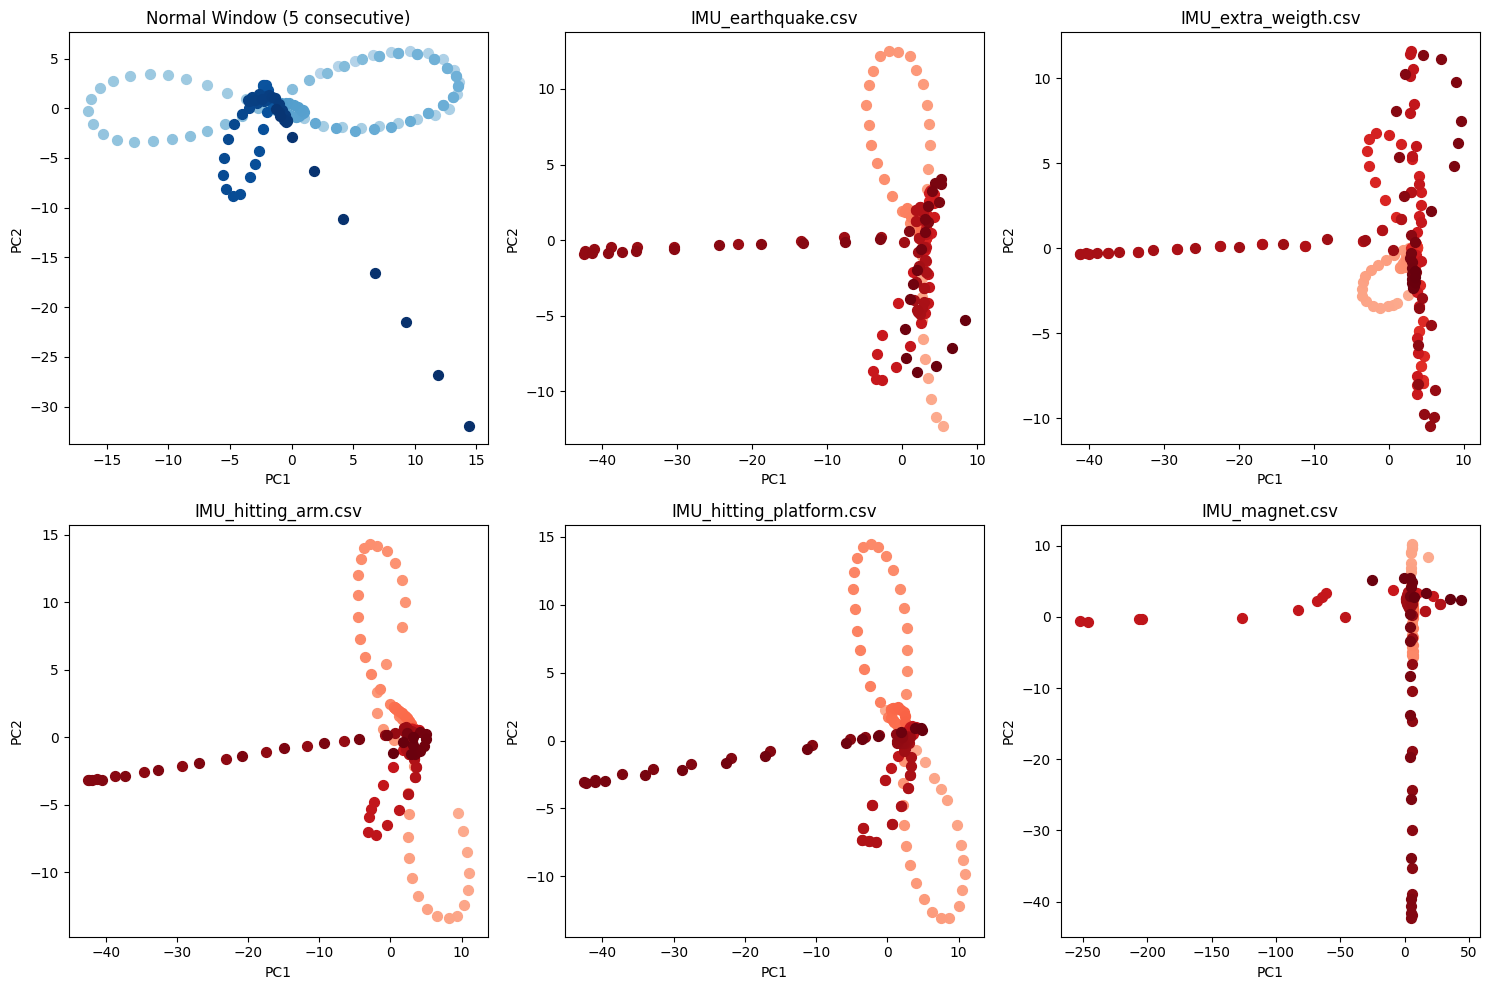

In [30]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# most similar candidate per anomaly type
candidates = []

# Calculate distances from randomNormalWindow to all training samples
for anomaly, name in zip(anomalo_tests, pp.anomalo_nomes):
    distances = euclidean_distances(randomNormalWindow[2].reshape(1, -1), anomaly).flatten()
    mostSimilarIndex = np.argsort(distances)[0]
    # Ensure we don't go out of bounds
    start_idx = max(0, mostSimilarIndex - 1)
    end_idx = min(len(anomaly), mostSimilarIndex + 3)
    candidates.append((anomaly[start_idx:end_idx], name))

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)

# Reshape normal window for plotting (5 windows, each 60x10)
normalWindow_w = randomNormalWindow.reshape(4, 60, 10)

# Create a figure with subplots for each candidate + normal window
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot normal window (all 5 windows concatenated)
all_normal_points = normalWindow_w.reshape(-1, 10)  # 300 points x 10 features
colors_normal = plt.cm.get_cmap('Blues')(np.linspace(0.3, 1, len(all_normal_points)))
pca_normal = pca.fit_transform(all_normal_points)
for i in range(len(all_normal_points)):
    axes[0].scatter(pca_normal[i, 0], pca_normal[i, 1], color=colors_normal[i], s=50)
axes[0].set_title('Normal Window (5 consecutive)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Plot each anomaly candidate
for idx, (cand, name) in enumerate(candidates):
    # Reshape candidate windows (variable number of windows, each 60x10)
    cand_w = cand.reshape(-1, 10)  # Flatten all windows to points x 10 features
    colors_anomaly = plt.cm.get_cmap('Reds')(np.linspace(0.3, 1, len(cand_w)))
    pca_cand = pca.fit_transform(cand_w)
    for i in range(len(cand_w)):
        axes[idx + 1].scatter(pca_cand[i, 0], pca_cand[i, 1], color=colors_anomaly[i], s=50)
    axes[idx + 1].set_title(name)
    axes[idx + 1].set_xlabel('PC1')
    axes[idx + 1].set_ylabel('PC2')

plt.tight_layout()
plt.show()
